In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

from scipy.stats import zscore
from umap import UMAP
import umap

import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
machine_type = 'pump'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

In [9]:
data_types = ['train', 'valid_source', 'valid_target']

In [38]:
data_type = data_types[0]

feats = ext_data[data_type]['features']
labels = ext_data[data_type]['labels']
wav_names = ext_data[data_type]['wav_names']
#data_types = [data_type] * len(ext_data[data_type]['labels'])

In [39]:
section_types = com.get_section_types(wav_names)

# Describe

In [14]:
#pd.set_option('display.max_columns', 5000)
#feat_df.describe()

In [15]:
pd.set_option('display.max_columns', 50)

In [16]:
corrmat = pd.DataFrame(np.corrcoef(feats.T))

/home/hiroki/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/hiroki/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<ipython-input-17-e9ff5c3bdb10>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad("k",1.)


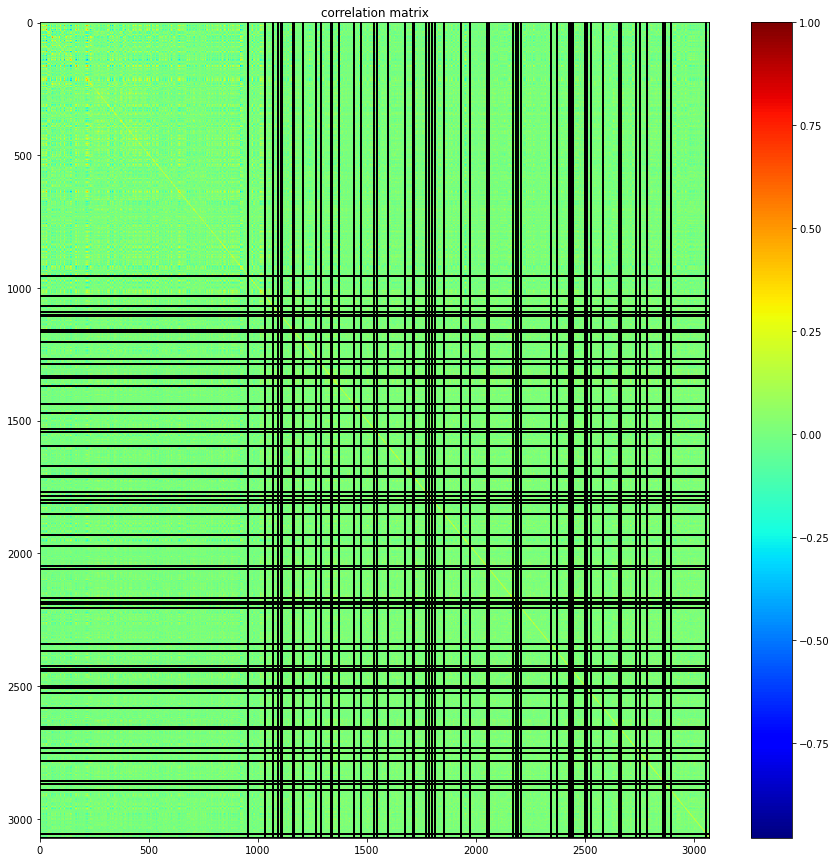

In [17]:
plt.figure(figsize=(15,15))
cmap = plt.cm.jet
cmap.set_bad("k",1.)
plt.imshow(corrmat, aspect='auto', cmap=cmap)
plt.title('correlation matrix')
plt.colorbar()

# umap

In [18]:
feats.shape

(6018, 3072)

In [19]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0)
new_feats = vt.fit_transform(feats)

In [20]:
new_feats.shape

(6018, 3015)

In [42]:
%%time
mapper = UMAP(n_components=2, random_state=42, n_neighbors=15, metric='correlation')
embedding = mapper.fit_transform(feats)

CPU times: user 44.8 s, sys: 229 ms, total: 45 s
Wall time: 23 s


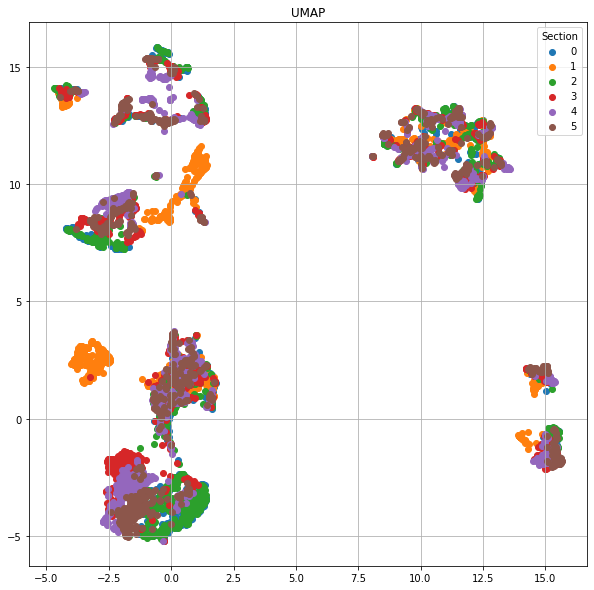

In [43]:
plt.figure(figsize=(10,10))
plt.title('UMAP')

embedding_x = embedding[:, 0]
embedding_y = embedding[:, 1]
for n in np.unique(section_types):
    plt.scatter(embedding_x[section_types == n],
                embedding_y[section_types == n],
                label=n)
plt.grid()
plt.legend(title='Section')
plt.show()

In [17]:
%%time
mapper = UMAP(n_components=2, random_state=42, n_neighbors=15, densmap=True)
embedding = mapper.fit_transform(feats)

CPU times: user 20 s, sys: 91.9 ms, total: 20.1 s
Wall time: 18.7 s


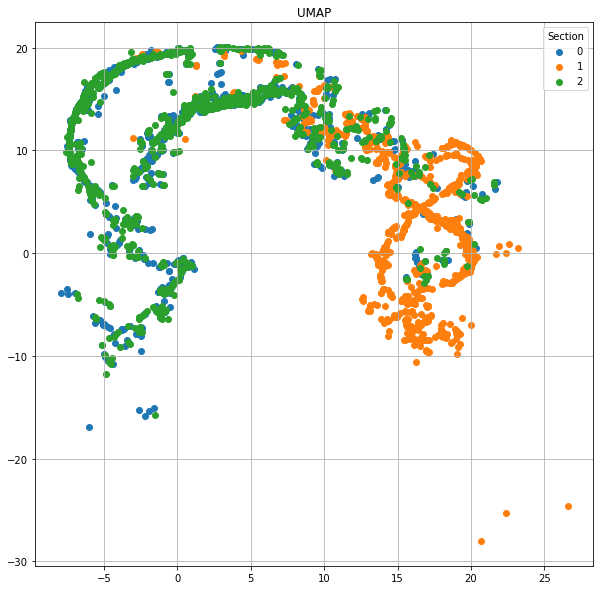

In [18]:
plt.figure(figsize=(10,10))
plt.title('UMAP')

embedding_x = embedding[:, 0]
embedding_y = embedding[:, 1]
for n in np.unique(section_types):
    plt.scatter(embedding_x[section_types == n],
                embedding_y[section_types == n],
                label=n)
plt.grid()
plt.legend(title='Section')
plt.show()

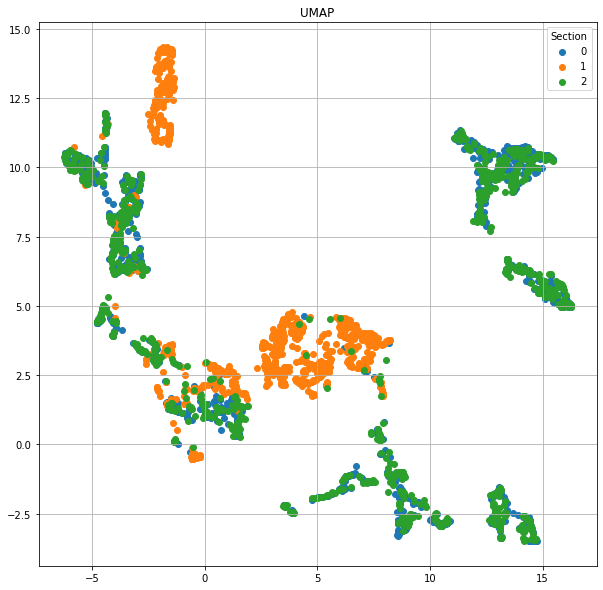

In [23]:
plt.figure(figsize=(10,10))
plt.title('UMAP')

embedding_x = embedding[:, 0]
embedding_y = embedding[:, 1]
for n in np.unique(section_types):
    plt.scatter(embedding_x[section_types == n],
                embedding_y[section_types == n],
                label=n)
plt.grid()
plt.legend(title='Section')
plt.show()

In [35]:
mapper.

False

# GMM

In [68]:
from sklearn.mixture import GaussianMixture

In [69]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(feats)

GaussianMixture(n_components=3, random_state=42)

In [71]:
gmm_section_types = gmm.predict(feats)

/home/hiroki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

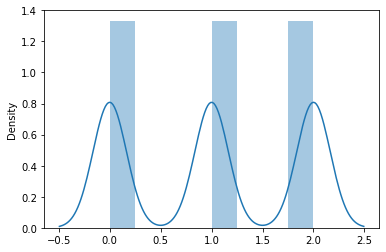

In [75]:
sns.distplot(section_types)

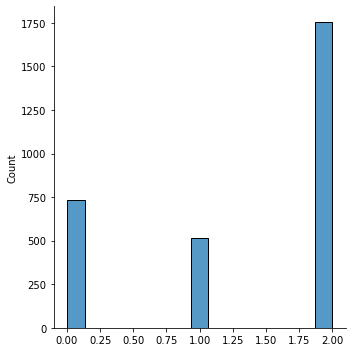

In [74]:
sns.displot(gmm_section_types)